Want to build the vectors and get the hypotheses at each timestep so they can be properly scores

In [2]:
import pandas as pd
import numpy as np

Make dummy detections. First with no simultaneous detections

In [3]:
detections = pd.DataFrame()
detections["id"] = [0, 1, 2]
detections["time"] = [0, 1,2]
detections["object_location"] = [0, 1, 2]

In [4]:
import matplotlib.pyplot as plt

/home/nader/Projects/thesis/benthic_targets/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


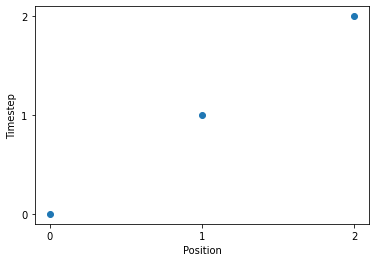

In [5]:
fig, ax = plt.subplots()

ax.scatter(detections.object_location, detections.time)

ax.set_xlabel("Position")
ax.set_ylabel("Timestep")

ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])

fig.show()

In [16]:
def make_first_branches(det_t):
    new_branches = []
    for i, row in det_t.iterrows():
        new_br = np.array([row["id"]])
        new_branches.append(new_br)
    return new_branches

In [6]:
def make_new_branches(branches, det_t, it):
    new_branches = []

    old_it = len(branches[0])

    nan_append = np.empty(it - old_it) + np.NaN

    bz = []
    for br in branches:
        bz.append(np.append(br, nan_append))

    branches = bz
    # new_branches = []
    if len(det_t) == 1:
        # create new vector (case where this detection is a new individual)
        d = det_t.iloc[0]
        new_br = np.empty(it + 1)
        new_br[:] = np.NaN
        new_br[it] = d["id"]
        new_branches.append(new_br)

        for i, br in enumerate(branches):
            # case where this is a repeat of the last observed
            new_br_repeat = np.append(br, d["id"])
            new_branches.append(new_br_repeat)

            # get the id of the previous detection in the current branch


            # case where it's not
            new_br_no_repeat = np.append(br, np.NaN)
            new_branches.append(new_br_no_repeat)

    else:
        for i, br in enumerate(branches):

            for i, d in det_t.iterrows():
                # create new vector (case where this detection is a new individual)
                new_br = np.empty(it + 1)
                new_br[:] = np.NaN
                new_br[it] = d["id"]

                new_branches.append(new_br)

                new_br_repeat = np.append(br, d["id"])
                new_branches.append(new_br_repeat)

                # get the id of the previous detection in the current branch

            new_br_no_repeat = np.append(br, np.NaN)
            new_branches.append(new_br_no_repeat)
            
            
    return new_branches
   


In [7]:
det_0 = detections[detections["time"]==0]

br = make_first_branches(det_0)
br

[array([0])]

In [15]:
det_1 = detections[detections["time"]==1]
br1 = make_new_branches(br, det_1, 1)
for b in br1:
    print(b)

NameError: name 'make_new_branches' is not defined

In [8]:
import igraph
import itertools

In [9]:
def make_tree_compat(trees):
    trees = np.array(trees)
    tree_compat = np.zeros((len(trees), len(trees)))

    for step in trees.transpose():
        unique, counts = np.unique(step, return_counts=True)
        reps = unique[np.where(counts > 1)]
        for r in reps:
            if r >= 0:
                whr = np.where(step == r)
                for pair in itertools.permutations(whr[0], r=2):
                    tree_compat[pair] = 1
    return tree_compat

def make_hypotheses_from_trees(trees):

    tree_compat = make_tree_compat(trees)
    g = igraph.Graph()
    nverts = len(trees)
    g.add_vertices(nverts)
    labels = []
    edges = []
    for i in range(nverts):
        labels.append(str(i))
        for ed in np.where(tree_compat[i] ==1)[0]:
            edges.append((i,ed))


    g.vs["label"] = labels

    g.add_edges(edges)
    hyps =  g.maximal_independent_vertex_sets()
    return hyps


In [10]:
br

[array([0])]

In [11]:
hyps = make_hypotheses_from_trees(br)
hyps

[(0,)]

In [12]:
for hyp in hyps:
    print(hyp)
    for i in hyp:
        print(br[i])

(0,)
[0]


Go through each hypothesis:
1. Calculate the score
2. generate branches for the next timestep

Calculating next hypotheses from hypothesis set and new detection

In [13]:
hyps

[(0,)]

In [17]:
det_1 = detections[detections["time"]==1]

In [18]:
print(hyps)
print(det_1)

[(0,)]
   id  time  object_location
1   1     1                1


In [108]:
detection_id = det_1.iloc[0].id
detection_time = det_1.iloc[0].time
detection_pos = det_1.iloc[0].object_location
hyps = [[[0]]]

new_hyps = []
# go through hypotheses
for hyp in hyps:
    # go through the branches in the hypothesis
    for branch in hyp:
        # scenario where the new detection is a repeat
        repeat_scen = [branch + [detection_id]]
        new_hyps.append(repeat_scen)
        
        # scenario where the new detection is a new individual
        new_scen = [branch + [np.nan], list(np.empty(len(branch)) * np.nan) + [detection_id]]
        new_hyps.append(new_scen)
        
        
        

In [109]:
new_hyps

[[[0, 1]], [[0, nan], [nan, 1]]]

In [110]:
hyps = new_hyps
det_2 = detections[detections["time"]==2]
detection_id = det_2.iloc[0].id
detection_time = det_2.iloc[0].time
detection_pos = det_2.iloc[0].object_location

new_hyps = []
# go through hypotheses
for hyp in hyps:
    
    # scenario where the new detection is a new individual
    # pad existing branches
  
    new_scen = [ h + [np.nan] for h in hyp] + [list(np.empty(len(hyp[0]))*np.nan) + [detection_id]]
    new_hyps.append(new_scen)
    
    print(new_scen)
    # go through the branches in the hypothesis
    for i, branch in enumerate(hyp):
        # scenario where the new detection is a repeat
        repeat_scen = [branch + [detection_id]]
        repeat_scen += [hyp[j] + [np.nan]  for j in range(len(hyp)) if j!=i]
        
        new_hyps.append(repeat_scen)
        

        
        

[[0, 1, nan], [nan, nan, 2]]
[[0, nan, nan], [nan, 1, nan], [nan, nan, 2]]


In [111]:
for h in hyps:
    print(h)

[[0, 1]]
[[0, nan], [nan, 1]]


In [112]:
for h in new_hyps:
    print(h)

[[0, 1, nan], [nan, nan, 2]]
[[0, 1, 2]]
[[0, nan, nan], [nan, 1, nan], [nan, nan, 2]]
[[0, nan, 2], [nan, 1, nan]]
[[nan, 1, 2], [0, nan, nan]]


In [53]:
a += [1]

In [54]:
a

[0, 1]

In [52]:
[a[i] for i in range(len(a)) if i!=0]


[]

In [14]:
hyps = make_hypotheses_from_trees(br1)
for hyp in hyps:
    branch_indices = [h for h in hyp]
    print(branch_indices)
    print(np.array(br1)[branch_indices])
            
            
    

[0, 2]
[[nan  1.]
 [ 0. nan]]
[1]
[[0. 1.]]


In [29]:
a = [0]
[a+[1]]

[[0, 1]]

In [16]:
blah = make_hypotheses_from_trees(br1)
blah

[(0, 2), (1,)]

In [28]:
inds = [b for b in blah[0]]
np.array(br1)[inds]

array([[nan,  1.],
       [ 0., nan]])

In [ ]:
det_2 = detections[detections["time"]==2]
br2 = make_new_branches(br1, det_1, 2)
br2